# А	Анализ и предобработка данных

In [1]:
import glob
import shutil
import os

from collections import Counter

import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import xml.etree.ElementTree as xet

## 1	Структурирование данных


Посмотрим какие разрешения бывают у наших файлов:

In [2]:
arr = []
for i in range(1, 4):
    for dir1 in ['test', 'train', 'valid', 'annotations', 'images']:
        arr += list(map(lambda x: x[-4:],glob.glob(f'./data/Data{i}/{dir1}/*')))
print(set(arr))

{'.jpg', '.xml', '.png'}


Cоединим все наши датасеты в одну папку со структурой annotations, images, для удобства работы и обучения нашей модели

При этом изменим png расширения на jpg, для приведения к одному виду и т.к. изображений jpg больше:

In [3]:
Counter(arr)

Counter({'.xml': 2421, '.jpg': 1988, '.png': 433})

Сначала все файлы объединим в одной папке

In [4]:
os.makedirs('./data/extracted/images', exist_ok=True)
os.makedirs('./data/extracted/annotations', exist_ok=True)
for i in range(1, 4):
    for dir1 in ['test', 'train', 'valid', 'annotations', 'images']:
        for filename in glob.glob(f'./data/Data{i}/{dir1}/*'):
            if filename.endswith('.png'):
                shutil.copy(filename,f'./data/extracted/{os.path.basename(filename)[:-4] + ".jpg"}')
            else:
                shutil.copy(filename,'./data/extracted')

И объединим в соответствующие директории по расширениям

In [5]:
for filename in glob.glob(f'./data/extracted/*.*'):
    if filename.endswith('.jpg'):
        shutil.move(filename,'./data/extracted/images')
    else:
        shutil.move(filename,'./data/extracted/annotations')
os.makedirs('./data/extracted/labels', exist_ok=True)

## 2	Разметка данных


## После шаманства с бубном и координатной плоскостью можем вывести нормальные боксы

640.0 640.0
./data/extracted/annotations\20230111204914_H309TC777_jpg.rf.a4fc7d4e117e21284ba7318532745dc2.xml
[287, 218, 337, 258]
1920.0 1080.0
./data/extracted/annotations\---------------668-_png.rf.9410965a481d4554c3e1502b7f5f9194.xml
[598, 380, 710, 437]
640.0 640.0
./data/extracted/annotations\20230105031519_M983HH799_jpg.rf.6c45f8a21979c9cb3dc3216ea585ad4e.xml
[225, 236, 272, 270]
640.0 640.0
./data/extracted/annotations\20230114201701_E637AK977_jpg.rf.ce38316e0d4724a2a381aac27f84de29.xml
[313, 238, 371, 279]


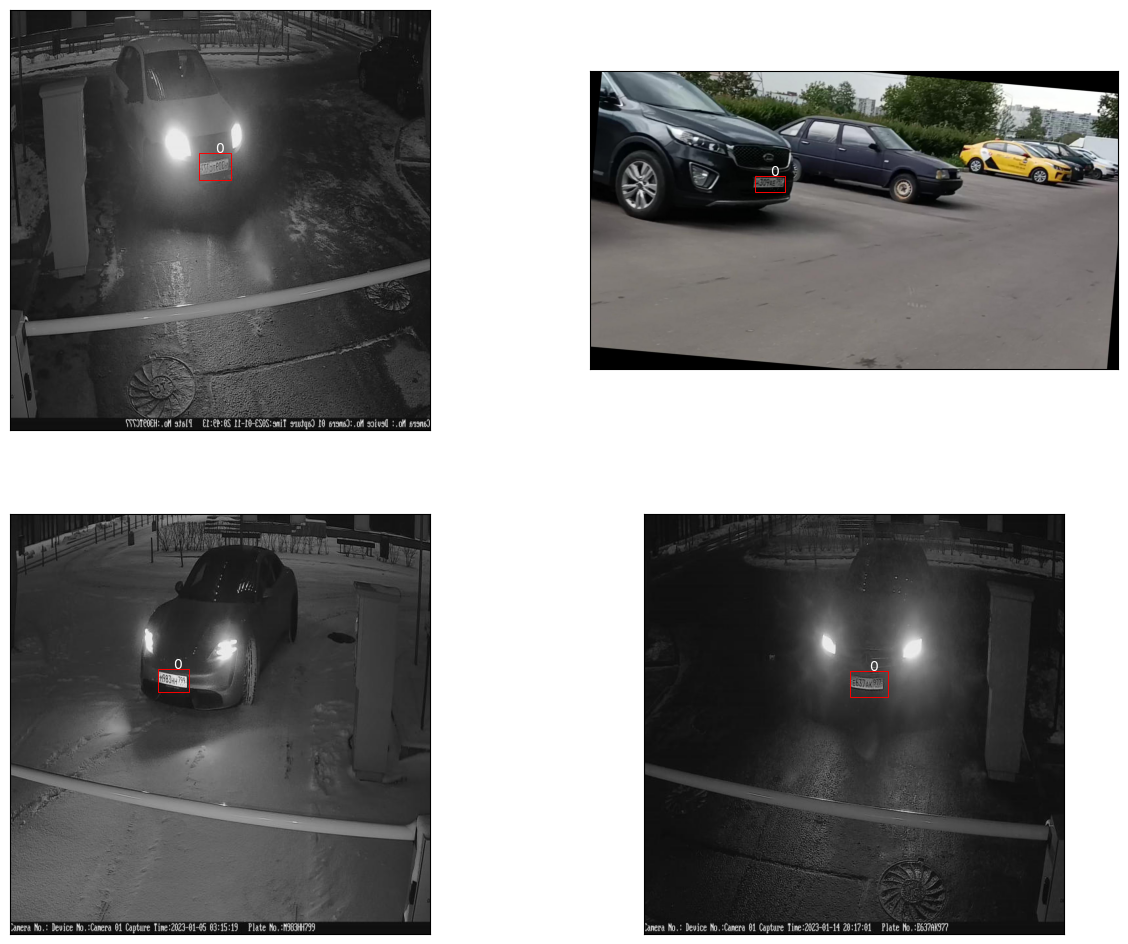

In [7]:
annot_filenames = glob.glob('./data/extracted/annotations/*.xml')
img_filenames = glob.glob('./data/extracted/images/*.jpg')

path = './data/extracted'
txts = os.listdir(os.path.join(path, 'labels'))
imgs = os.listdir(os.path.join(path, 'images'))
txts_with_classes = {}
for txt in txts:
    with open(os.path.join(r'./data/extracted/labels', txt), 'r') as file:
        lines = file.readlines()
        for line in lines:
            try:
                txts_with_classes[txt[:-4] + '.jpg'] += [int(line[:1])]
            except KeyError:
                txts_with_classes[txt[:-4] + '.jpg'] = [int(line[:1])]

classes_list = [0]

for damage_class in range(1):
    scale = 2
    fig, axes = plt.subplots(nrows=scale, ncols=scale, figsize=(15, 12),  #Размер вывода
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes):
        for count in range(scale):   
            rand_indx = random.randint(0, len(annot_filenames) - 1)
            info = xet.parse(annot_filenames[rand_indx])
            root = info.getroot()
            img_size = root.find('size')
            img_width = float(img_size.find('width').text)
            img_height = float(img_size.find('height').text)
            print(img_width, img_height)
            box_objects = root.findall('object')
            img = plt.imread(img_filenames[rand_indx])
            ax[count].imshow(img)
            print(annot_filenames[rand_indx])
            for box in box_objects:
                labels_info = box.find('bndbox')
                xmin = int(labels_info.find('xmin').text)
                xmax = int(labels_info.find('xmax').text)
                ymin = int(labels_info.find('ymin').text)
                ymax = int(labels_info.find('ymax').text)
                bbox = [xmin, ymin, xmax, ymax]

                print(bbox)
                rect = patches.Rectangle((xmin, ymin), abs(xmin - xmax) , abs(ymin - ymax), linewidth=0.7, edgecolor='r',
                                         facecolor='none')
                ax[count].text((xmax - xmin) / 2 + xmin, ymin, classes_list[damage_class], color='white')
                ax[count].add_patch(rect)

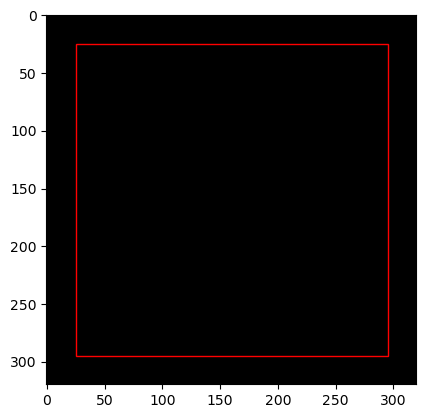

In [8]:
img = np.zeros((320,320,3))
plt.imshow(img)
rect = patches.Rectangle((25, 25), 270 , 270, linewidth=1, edgecolor='r',
                         facecolor='none')
plt.gca().add_patch(rect)

In [9]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

for filename in glob.glob('./data/extracted/annotations/*.xml'):
    info = xet.parse(filename)
    root = info.getroot()
    img_size = root.find('size')
    print(img_size.find('width').text,img_size.find('height').text)
    img_width = float(img_size.find('width').text)
    img_height = float(img_size.find('height').text)
    print(img_width,img_height)
    box_objects = root.findall('object')
    #print(filename)
    for box in box_objects:
        labels_info = box.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)
        bbox = [xmin, ymin, abs(xmin - xmax) , abs(ymin - ymax)]
        bbox = convert_bbox_coco2yolo(img_width,img_height,bbox)
        print(bbox)
        # print(' '.join(['0'] + list(map(str,bbox))))
        # print(os.path.join('./data/extracted/labels',os.path.basename(filename)[:-4]+'.txt'))
        with open(os.path.join('./data/extracted/labels',os.path.basename(filename)[:-4]+'.txt'),'a') as f:
            f.write(' '.join(['0'] + list(map(str,bbox)))+'\n')

1920 1080
1920.0 1080.0
[0.1390625, 0.537962962962963, 0.046875, 0.02962962962962963]
[0.73984375, 0.42638888888888893, 0.018229166666666668, 0.01388888888888889]
1920 1080
1920.0 1080.0
[0.13828125, 0.5041666666666667, 0.04635416666666667, 0.025]
[0.7416666666666667, 0.44953703703703707, 0.017708333333333333, 0.012037037037037037]
1920 1080
1920.0 1080.0
[0.096875, 0.5819444444444445, 0.04895833333333333, 0.036111111111111115]
[0.7651041666666667, 0.4189814814814815, 0.01875, 0.015740740740740743]
1920 1080
1920.0 1080.0
[0.09401041666666667, 0.5064814814814815, 0.04739583333333333, 0.02777777777777778]
[0.7684895833333333, 0.46851851851851856, 0.018229166666666668, 0.012962962962962964]
1920 1080
1920.0 1080.0
[0.9263020833333333, 0.42453703703703705, 0.0265625, 0.025]
1920 1080
1920.0 1080.0
[0.928125, 0.46342592592592596, 0.026041666666666668, 0.02314814814814815]
1920 1080
1920.0 1080.0
[0.15234375, 0.44027777777777777, 0.058854166666666666, 0.03425925925925926]
1920 1080
1920.0 1

Cars148.jpg 225 400
0 0.44125000000000003 0.6488888888888888 0.20750000000000002 0.10666666666666666

20230114155527_O840CH777_jpg.rf.9c42062524f81823f3f8f4a007e28541.jpg 640 640
0 0.48984375 0.38515625000000003 0.0703125 0.0578125

20230102070343_A999KE99_jpg.rf.6262aeacad392db7741ec4c24555008c.jpg 640 640
0 0.4078125 0.38515625000000003 0.08750000000000001 0.0546875

Cars400.jpg 267 400
0 0.80375 0.7640449438202247 0.0925 0.09737827715355805


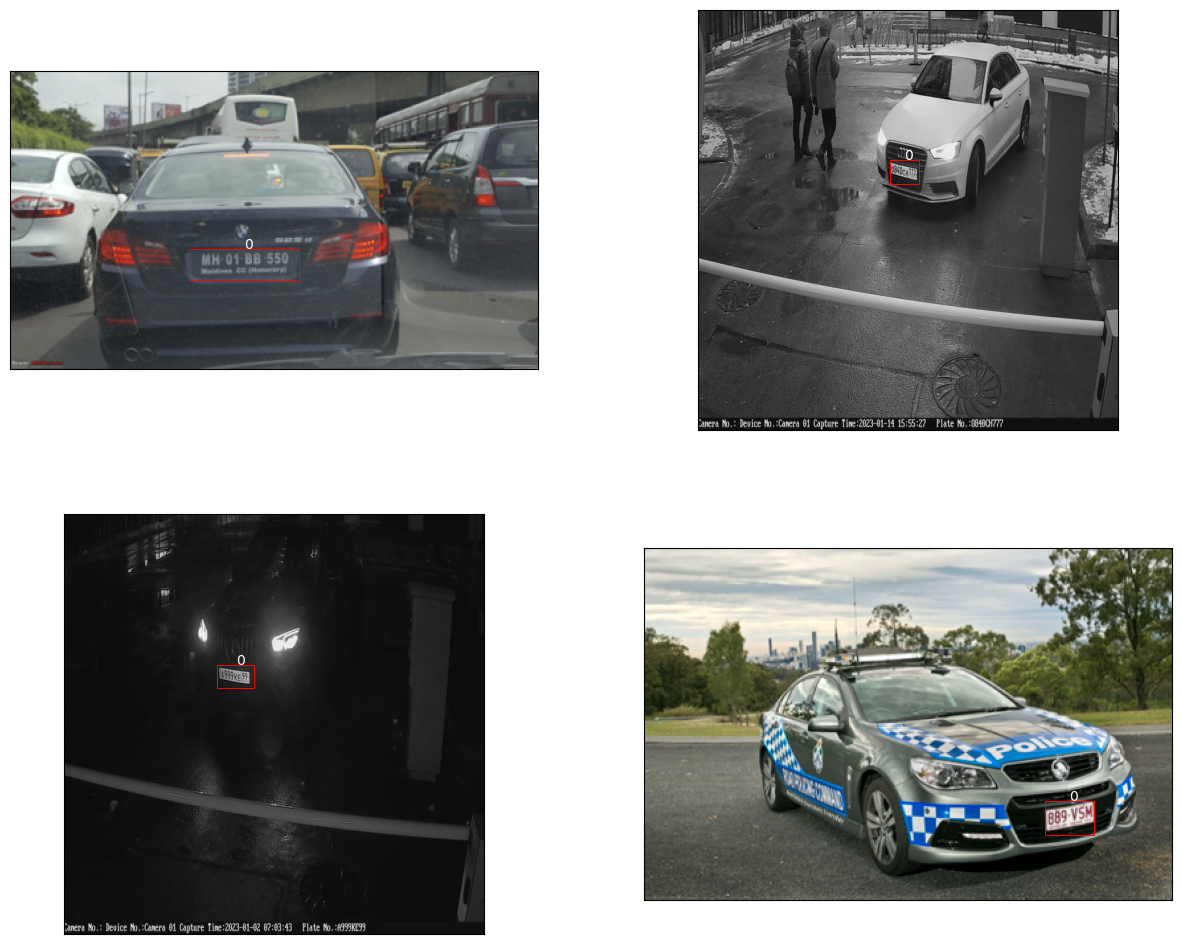

In [13]:
path = './data/extracted'
txts = os.listdir(os.path.join(path, 'labels'))
imgs = os.listdir(os.path.join(path, 'images'))
txts_with_classes = {}
for txt in txts:
    with open(os.path.join(r'./data/extracted/labels', txt), 'r') as file:
        lines = file.readlines()
        for line in lines:
            try:
                txts_with_classes[txt[:-4] + '.jpg'] += [int(line[:1])]
            except KeyError:
                txts_with_classes[txt[:-4] + '.jpg'] = [int(line[:1])]

classes_list = [0]

for damage_class in range(1):
    # try:
        scale = 2
        class_indx = [i for i, x in enumerate(map(lambda x: damage_class in x, txts_with_classes.values())) if
                      x == True]

        fig, axes = plt.subplots(nrows=scale, ncols=scale, figsize=(15, 12),  #Размер вывода
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes):
            for count in range(scale):
                jpg_name = list(txts_with_classes)[class_indx[random.randrange(0, len(class_indx))]]  # image_indx
                img = plt.imread(os.path.join('./data/extracted/images', jpg_name))
                ax[count].imshow(img)
                h, w = np.shape(img)[0], np.shape(img)[1]
                print(jpg_name,h,w)
                txt_name = jpg_name[:-4] + '.txt'
                with open(os.path.join('./data/extracted/labels', txt_name)) as file:
                    lines = file.readlines()
                    for line in lines:
                        print(line)
                        if line[0] == f'{damage_class}':
                            _, x_, y_, w_, h_ = list(map(float, line.split()))
                            x1 = w * x_ - 0.5 * w * w_
                            y1 = h * y_ - 0.5 * h * h_
                            x2 = w * x_ + 0.5 * w * w_
                            y2 = h * y_ + 0.5 * h * h_
                            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=0.7, edgecolor='r',
                                                     facecolor='none')
                            ax[count].text((x2 - x1) / 2 + x1, y1, classes_list[damage_class], color='white')
                            ax[count].add_patch(rect)
    # except:
    #     pass

### С кайфом

### Проверка на нули нулей нету

In [2]:
data = []
root = r'.\data\extracted'
space_count = 0
transfer_count = 0
txt_files = os.listdir(os.path.join(root, 'labels'))
for txt_file in txt_files:
    txt_path = os.path.join(root, 'labels', txt_file)
    with open(txt_path, 'r') as file:
        text = file.read()
        data.append(text)
print(Counter(data))

Counter({'0 0.20182291666666666 0.3856481481481482 0.050520833333333334 0.026851851851851852\n0 0.8484375 0.5180555555555556 0.019791666666666666 0.015740740740740743\n': 2, '0 0.6489583333333333 0.40046296296296297 0.034375 0.032407407407407406\n0 0.81875 0.2814814814814815 0.08958333333333333 0.07037037037037037\n': 2, '0 0.7890625 0.35694444444444445 0.06666666666666667 0.04722222222222222\n': 2, '0 0.3953125 0.1277777777777778 0.029166666666666667 0.024074074074074074\n0 0.5395833333333333 0.18194444444444446 0.04479166666666667 0.036111111111111115\n0 0.8223958333333333 0.250462962962963 0.0875 0.05277777777777778\n': 2, '0 0.4705729166666667 0.25972222222222224 0.05677083333333333 0.03796296296296296\n': 2, '0 0.1171875 0.43472222222222223 0.11041666666666666 0.08796296296296297\n0 0.48046875 0.3990740740740741 0.049479166666666664 0.04814814814814815\n': 2, '0 0.39765625 0.5689814814814815 0.11614583333333334 0.0638888888888889\n': 2, '0 0.3458333333333333 0.47314814814814815 0.

и слава богу

## Сохраняем разметку единым файлом

# Yolo-to-COCO-format-converter

In [18]:
!git clone https://github.com/Taeyoung96/Yolo-to-COCO-format-converter.git

Cloning into 'Yolo-to-COCO-format-converter'...


Изменяем классы на свои и директорию аннотаций в файле ./Yolo-to-COCO-format-converter/main.py

YOLO_DARKNET_SUB_DIR = "labels"
classes = [
    "license_plate"
]

Переносим файлы в папку для работы функции

In [19]:
os.makedirs('./data/yolo-to-coco_data/labels/', exist_ok=True)
shutil.copytree('./data/extracted/images','./data/yolo-to-coco_data/',dirs_exist_ok=True)
shutil.copytree('./data/extracted/labels','./data/yolo-to-coco_data/labels/',dirs_exist_ok=True)

'./data/yolo-to-coco_data/labels/'

In [20]:
%cd Yolo-to-COCO-format-converter
!python main.py --yolo-subdir --path ..\data\yolo-to-coco_data\ --output all.json
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\car_license-plate\A\Yolo-to-COCO-format-converter
Start!

Processing 0 ...
Processing 1 ...
Processing 2 ...
Processing 3 ...
Processing 4 ...
Processing 5 ...
Processing 6 ...
Processing 7 ...
Processing 8 ...
Processing 9 ...
Processing 10 ...
Processing 11 ...
Processing 12 ...
Processing 13 ...
Processing 14 ...
Processing 15 ...
Processing 16 ...
Processing 17 ...
Processing 18 ...
Processing 19 ...
Processing 20 ...
Processing 21 ...
Processing 22 ...
Processing 23 ...
Processing 24 ...
Processing 25 ...
Processing 26 ...
Processing 27 ...
Processing 28 ...
Processing 29 ...
Processing 30 ...
Processing 31 ...
Processing 32 ...
Processing 33 ...
Processing 34 ...
Processing 35 ...
Processing 36 ...
Processing 37 ...
Processing 38 ...
Processing 39 ...
Processing 40 ...
Processing 41 ...
Processing 42 ...
Processing 43 ...
Processing 44 ...
Processing 45 ...
Processing 46 ...
Processing 47 ...
Processing 48 ...
Processing 49

и перемещаем этот json

In [21]:
shutil.move('./Yolo-to-COCO-format-converter/output/all.json','./data/yolo-to-coco_data')

'./data/yolo-to-coco_data\\all.json'

Собираем наши данные для удобства

In [22]:
shutil.rmtree('./data/yolo-to-coco_data/labels')
os.mkdir('./data/yolo-to-coco_data/images')
for img in glob.glob('./data/yolo-to-coco_data/*.jpg'):
    shutil.move(img,'./data/yolo-to-coco_data/images')

# Анализ данных

Наши данные Data1-3 представляют из себя директории, содержащие в себе различного рода разметки в формате xml и картинки на которых эти данные размечены. В папках Data1-2 картинки и их разметки распределены по папкам test train valid в Data1 и train valid в Data2. В Data3 разметки лежат в директории annotations, а изображения в images без разделения на train test val. 

Просмотрим какие классы у нас существуют в каждой разметке:

In [26]:
classes = []
for filename in glob.glob('./data/extracted/annotations/*.xml'):
    info = xet.parse(filename)
    root = info.getroot()
    box_objects = root.findall('object')
    for box in box_objects:
        labels = [box.find('name').text]
        classes += labels
print(Counter(classes))

Counter({'car-plate-numbers': 1320, 'plate': 1127, 'licence': 471})


Всего три класса, но каждый из классов означает одно и тоже - автомобильный номер, поэтому в ходе парсинга данных с xml я не разделял наши классы и везде ставил класс 0

Кроме того что нам нужно на картинке найти наш номер также нам нужно его прочитать. В этом нам поможет только один набор данных - Data1, т.к. в названиях у изображений и разметок содержит этот номер между двух нижних подчёркиваний: 20230108210515_X973TO799_jpg.rf.2bb0fcab3119d3a98a97d6637edde275.jpg - у этого изображения номер X973TO799.

Что было проделано с набором данных:

- Соединение всех данных из Data1-3 
- Структурирование их по папкам annotations и images
- Парсинг xml разметок и преобразование их в формат yolo в папке labels
- Преобразование всех разметок в один файл all.json
- Структурирование папки yolo-to-coco_data 
- Проводились прочие аналитические вычисления

# Документация

Требуется титульный лист, содержание, разделы с новой страницы,

6.1 Построение документа
6.1.1 В общем случае в ТД. содержащие в основном сплошной текст, включают следующие структурные элементы:
- титульный лист;
- предисловие;
- содержание;
- обозначения и сокращения;
- термины и определения;
- основное тематическое содержание документа;
- приложения;
- ссылочные нормативные документы;
- ссылочные документы:
- библиография:
- лист регистрации изменений.

### Титульный лист

![](./static/img.png)

- поле 1 — наименование ведомства, в систему которого входит организация, разработавшая данный документ. Заполнение поля не обязательно.
- поле 2 — в левой части (для технических условий, эксплуатационных и ремонтных документов) —
код по действующему классификатору продукции, в правой части — специальные отметки. Заполняется только для титульного листа.

- поле 3 — в левой части — гриф согласования, в правой части — гриф утверждения, выполняемые
по ГОСТ Р 7.0.97. при необходимости:
- поле 4 — наименование изделия (прописными буквами) и документа, на который составляется
титульный лист или ЛУ. Если титульный лист составляется для документов, разбитых на части, указывают номер части и ее наименование. Для альбома документов указывают номер альбома и общее
количество альбомов, например:

![](./static/img_1.png)

- поле 5 — слова «Лист утверждения»: поле заполняют только для ЛУ;
- поле 6 — для титульного листа — обозначение документа (прописными буквами), для альбома
документов — обозначение описи этого альбома; для ЛУ — обозначение ЛУ;
- поле 7 — количество листов ЛУ. Поле но заполняют, если ЛУ выполнен на одном листе;
- поле 8 — для титульного листа: подписи разработчиков документа, выполняемые согласно
ГОСТ Р 7.0.97. Если документ подлежит согласованию с несколькими должностными лицами, то кроме
подписей, указанных в поле 3. остальные подписи располагают в левой части поля 8.
Подписи, указанные в основной надписи заглавного листа, не должны повторяться на титульном
листе и листе утверждения.
Для ЛУ: слева — гриф согласования (при необходимости), справа — подписи разработчиков и
нормоконтролера по ГОСТ Р 7.0.97 в порядке, установленном на предприятии-разработчике.
При большом количестве подписей поле 8 увеличивают за счет выпуска второго листа. При этом
на ном в верхнем правом углу указывают: для титульного листа «Продолжение титульного листа», для
ЛУ — «Продолжение листа утверждения» и далее наименование и обозначение документа. В этом
случае в конце первого листа указывают: «Продолжение на следующем листе»;
- поле 9 — графы 19 — 23 по ГОСТ 2.104. размещаемые на поле для подшивки. Допускается располагать поле 9 на поле 10 по ГОСТ 2.004;
- поле 10 — графы 14 — 18 по ГОСТ 2.104 (допускается размеры устанавливать произвольно: линии. разделяющие графы и строки, не наносят; наименование граф не указывают). Поле заполняют
строками снизу вверх. Поле заполняется только для ЛУ.

![](./static/slide-3.jpg)

### Типы разметки

![](https://habrastorage.org/r/w1560/webt/vl/uq/pu/vluqpuelfyewi3-rmeertk27b7s.jpeg)